In [1]:
import os
import sys

# Get the current working directory and add the parent directory to the Python path
current_working_directory = os.getcwd()
print(os.path.join(current_working_directory, ".."))
sys.path.append(os.path.join(current_working_directory, ".."))

/Users/L024258/lilly_work/github-copilot/exploration/langgraph/..


In [2]:
import pprint

### Defining the Graph state

In [3]:
from typing import TypedDict, Annotated, List, Union
import operator
from IPython.display import Image, display

In [4]:
class AgentState(TypedDict):
    input: str
    messages: Annotated[list, operator.add]
    chat_history: Annotated[list, operator.add]

In [5]:
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_community.tools.tavily_search import TavilySearchResults

pubmed_search = PubmedQueryRun()
arxiv_search = ArxivQueryRun()
tavily_tool = TavilySearchResults(max_results=5)

# tools = [arxiv_search, pubmed_search, tavily_tool]
tools = [arxiv_search, pubmed_search]
tools = [arxiv_search]

In [6]:
from models.llm import LLM

model = LLM('gpt-4o-mini')
llm = model.load_model()

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def research_agent(data):
    print("----research node----")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI research assistant,"
                " Use the appropriate search tools to progress towards finding the relevant results."
                " Once you have the relevant search results, summarise them to answer the user query."
                "\nYou have access to the following search tools: {tool_names}."
            ),
            (
                "human",
                "\nUser Query: {input}"
            ),
            
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    agent = prompt | llm.bind_tools(tools)
    result = agent.invoke(data)
    return {'messages': [result]}

In [8]:
from langgraph.graph import StateGraph
workflow = StateGraph(AgentState)

workflow.add_node("research", research_agent)
workflow.set_entry_point("research")

In [9]:
from langgraph.prebuilt import ToolNode, tools_condition
tools_node = ToolNode(tools)
workflow.add_node("tools", tools_node)

In [10]:
workflow.add_conditional_edges(
    "research",
    tools_condition
)

In [11]:
workflow.add_edge("tools", "research")

**NOTE:** To use `langgraph.prebuilt.ToolNode` and `langgraph.prebuilt.tools_conditions` refer langgraph ToolNode [documentation](https://langchain-ai.github.io/langgraph/reference/prebuilt/). For custom applications, I prefer defining `ToolNode` and `route_tools` based on the application's requirements.

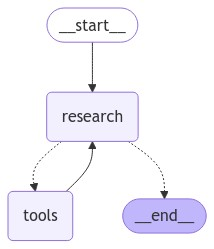

In [12]:
app = workflow.compile()
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
inputs = {
    "input": "What are the recent papers on Small Language Models?",
}

state = AgentState(**inputs)
for s in app.stream(input=state):
    print(list(s.values())[0]['messages'][0].content)
    print("-----"*20)

----research node----

----------------------------------------------------------------------------------------------------
Published: 2022-01-26
Title: An Assessment of the Impact of OCR Noise on Language Models
Authors: Konstantin Todorov, Giovanni Colavizza
Summary: Neural language models are the backbone of modern-day natural language
processing applications. Their use on textual heritage collections which have
undergone Optical Character Recognition (OCR) is therefore also increasing.
Nevertheless, our understanding of the impact OCR noise could have on language
models is still limited. We perform an assessment of the impact OCR noise has
on a variety of language models, using data in Dutch, English, French and
German. We find that OCR noise poses a significant obstacle to language
modelling, with language models increasingly diverging from their noiseless
targets as OCR quality lowers. In the presence of small corpora, simpler models
including PPMI and Word2Vec consistently outpe